In [1]:
import sys
sys.path.append('../src')

import torch
import numpy as np

import matplotlib.pyplot as plt
from modules import IDC
from utils import get_synthetic_dataset, plot_synthetic_dataset, clustering_accuracy
from trainer import idc_trainer, device

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

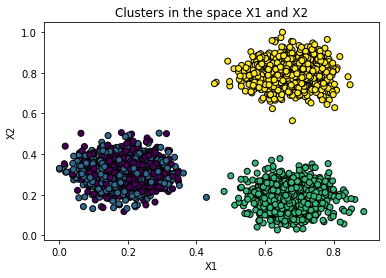

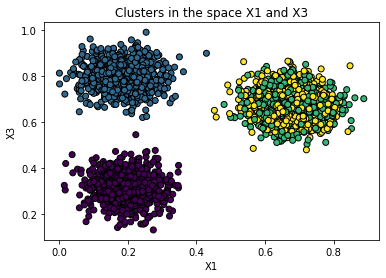

In [3]:
synthetic_X, synthetic_y = get_synthetic_dataset()
synthetic_X = (synthetic_X - synthetic_X.min()) / (synthetic_X.max() - synthetic_X.min())
plot_synthetic_dataset(synthetic_X, synthetic_y)

In [13]:
ae_gnn_config_train = {
    "batch_size":800, 
    "lr":1e-3,
    "local_gates_lmbd": 10,
    "reg_lmbd": 1,
    "epochs":300,
    "end_pretrain_epoch": 100,
    "eps": 1e-3,
}

clust_config_train = {
    "batch_size":800, 
    "lr_cluster_head": 1e-2,
    "lr_aux": 1e-1,
    "lr_zg": 1e-1,
    "epochs": 150,
    "end_pretrain_epoch": 100,
    "gamma": 4,
    "global_gates_lmbd": 1,
}


data_input_dim = 13
ae_layer_dims = [13, 10, 8]
gnn_hidden_dim = 16
cluster_hidden_dim = 2
nb_classes = 4

idc = IDC(data_input_dim, ae_layer_dims, gnn_hidden_dim, cluster_hidden_dim, nb_classes)

training_result = idc_trainer(idc, synthetic_X, ae_gnn_config_train, clust_config_train)

--------------------------------
Stage One Starting :


100%|██████████| 300/300 [00:09<00:00, 31.20it/s]


Stage One Finishing
--------------------------------

--------------------------------
Stage Two Starting :


100%|██████████| 150/150 [00:15<00:00,  9.39it/s]

Stage Two Finishing
--------------------------------


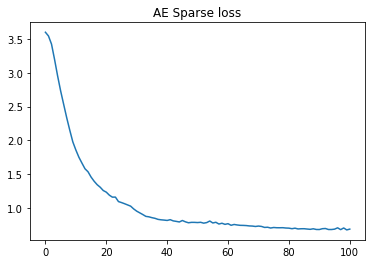

In [14]:
plt.plot(training_result["stage_one"]["ae_sparse_losses"])
plt.title("AE Sparse loss")
plt.show()

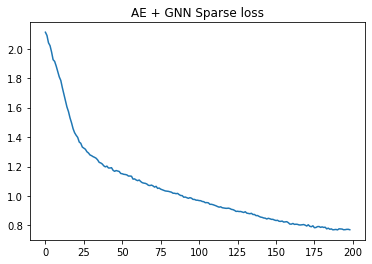

In [15]:
plt.plot(training_result["stage_one"]["ae_gnn_sparse_losses"])
plt.title("AE + GNN Sparse loss")
plt.show()

------------------------------
AE Fine-tuned , display for X
------------------------------


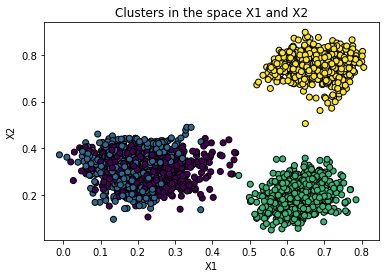

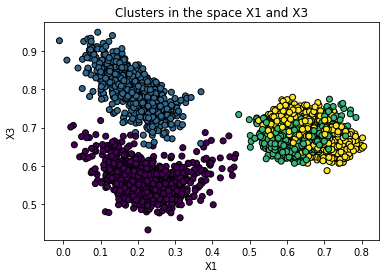

------------------------------
AE Fine-tuned , display for X_Z
------------------------------


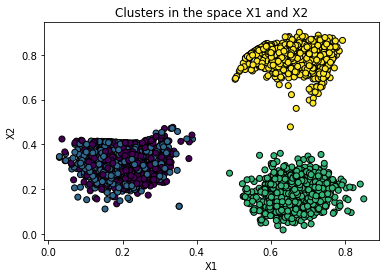

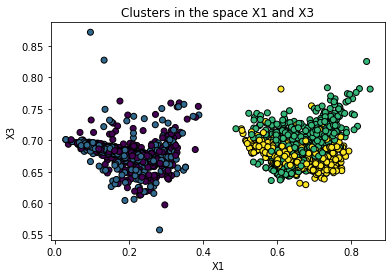

In [16]:
with torch.no_grad():
    X = synthetic_X.to(device)
    X_Z, z , _ = idc.gnn(X)
    X_z_hat = idc.ae(X_Z)
    X_hat = idc.ae(X)

    print("------------------------------")
    print("AE Fine-tuned , display for X")
    print("------------------------------")
    plot_synthetic_dataset(X_hat.cpu().detach().numpy(), synthetic_y)

    print("------------------------------")
    print("AE Fine-tuned , display for X_Z")
    print("------------------------------")
    plot_synthetic_dataset(X_z_hat.cpu().detach().numpy(), synthetic_y)

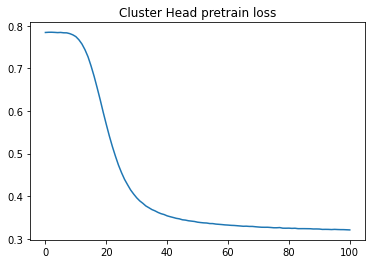

In [17]:
plt.plot(training_result["stage_two"]["clust_head_pretrain_losses"])
plt.title("Cluster Head pretrain loss")
plt.show()

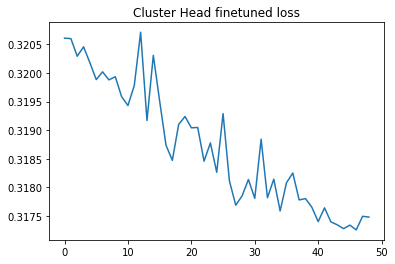

In [18]:
plt.plot(training_result["stage_two"]["clust_head_finetune_losses"])
plt.title("Cluster Head finetuned loss")
plt.show()

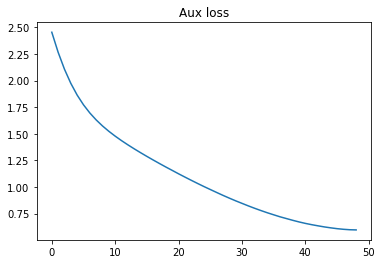

In [19]:
plt.plot(training_result["stage_two"]["aux_losses"])
plt.title("Aux loss")
plt.show()

In [20]:
with torch.no_grad():
    X = synthetic_X.to(device)
    X_Z ,z , _ = idc.gnn(X)
    H = idc.ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = idc.clusterNN(X_Z, H)
    clust_yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(clust_yhat, synthetic_y))
    print(np.unique(clust_yhat, return_counts=True))

0.496875
(array([0, 1]), array([2410,  790]))


In [12]:
from sklearn.cluster import KMeans

km = KMeans(4)

km.fit(synthetic_X)
km_yhat = km.predict(synthetic_X)

clustering_accuracy(km_yhat, synthetic_y)

/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1.0